The project shows two time series prediction techniques, the traditional ARIMA and the deep learning one called LSTM, applied to the electricity demand in California. The databases contain residential electricity demand, downloaded from the US Department of Energy website, and handled by the author. Two databases were separated to perform the predictions, hourly demand,and daily average demand. The ARIMA method proved to be more efficient for predicting hourly demand while the LSTM model was more efficient for predicting daily demand. The work also shows that the deep learning model is more efficient for predictions with larger databases than the traditional ARIMA model.

The Datasets were downloaded from the U.S. Energy Information Administration.
Available in:
https://www.eia.gov/electricity/data.php.


In [1]:
import pandas as pd

In [2]:
#Derive the id from the google drive shareable link.
#For the file at hand the link is as below
URL = 'https://drive.google.com/file/d/1KTGOotRMpF26heqzcFYEO9hHKVrzZ7k2/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df_hourly = pd.read_csv(path,
                       parse_dates=['time'])
df_hourly.head()

,Local date,Hour,week_day,month,year,time,mgw_demand,los_angeles_temp,san_diego_temp,san_francisco_temp,san_jose_temp,avg_temp_cities
0,1-Jul-15,8,Wed,7,2015,2015-07-01 08:00:00,34483,22.2,21.1,16.1,18.9,19.575
1,1-Jul-15,9,Wed,7,2015,2015-07-01 09:00:00,37003,22.2,21.7,18.3,21.7,20.975
2,1-Jul-15,10,Wed,7,2015,2015-07-01 10:00:00,39274,23.9,23.3,20.0,26.1,23.325
3,1-Jul-15,11,Wed,7,2015,2015-07-01 11:00:00,41265,23.9,23.3,21.1,29.4,24.425
4,1-Jul-15,12,Wed,7,2015,2015-07-01 12:00:00,43042,26.1,25.6,22.8,28.9,25.850


In [3]:
#Derive the id from the google drive shareable link.
#For the file at hand the link is as below
URL = 'https://drive.google.com/file/d/1tkfRajxzmZQcyufmFafa1ktmAwPYZfLp/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]

df_daily = pd.read_csv(path,
                        parse_dates=['time'])
df_daily.head()

,year,day,time,avg_mgw_demand,avg_temp_cities,avg_los_angeles_temp,avg_san_diego_temp,avg_san_francisco_temp,avg_san_jose_temp
0,2015,1-Jul,2015-07-01,43813.53,22.646875,22.947059,23.500000,18.888235,24.635294
1,2015,2-Jul,2015-07-02,40114.63,20.909375,21.841667,22.629167,17.762500,21.104167
2,2015,3-Jul,2015-07-03,36961.63,20.003125,20.262500,21.312500,17.620833,20.695833
3,2015,4-Jul,2015-07-04,34619.75,19.615625,19.933333,20.583333,17.425000,20.562500
4,2015,5-Jul,2015-07-05,32971.25,19.691667,19.737500,20.162500,18.825000,20.091667


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
from matplotlib import pyplot

C:\Users\Leopardo\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [5]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
get_ipython().run_line_magic('matplotlib', 'inline')

In [6]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

We have to transform the dates columns to an index

In [7]:
# Convert time to datetime object and set it as index

df_daily['time'] = pd.to_datetime(df_daily['time'], utc=True, infer_datetime_format=True)
time= df_daily.set_index('time')

In [8]:
# Convert time to datetime object and set it as index

df_hourly['time'] = pd.to_datetime(df_hourly['time'], utc=True, infer_datetime_format=True)
time= df_hourly.set_index('time')

In [9]:
df_daily.describe()

,year,avg_mgw_demand,avg_temp_cities,avg_los_angeles_temp,avg_san_diego_temp,avg_san_francisco_temp,avg_san_jose_temp
count,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000
mean,2018.228535,31516.735231,17.004700,18.544937,18.549329,14.823528,16.099783
std,1.889016,4635.683590,3.546474,3.870210,3.448614,3.182307,4.484003
min,2015.000000,22374.960000,7.833333,8.275000,10.437500,5.537500,5.116667
25%,2017.000000,28293.335000,14.260417,15.686458,15.944792,12.539583,12.595833
50%,2018.000000,30200.605000,16.946354,18.293750,18.285417,14.929167,16.297917
75%,2020.000000,34380.935000,19.877344,21.481250,21.213542,16.955208,19.354167
max,2021.000000,48356.630000,29.321875,32.687500,29.516667,28.383333,32.270833


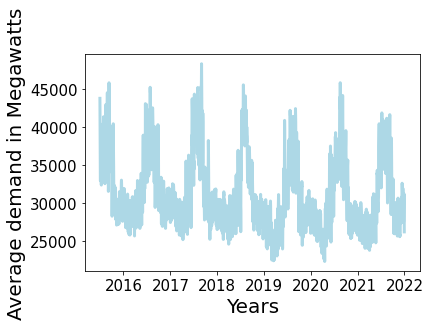

In [10]:
x = df_daily["time"]
y = df_daily["avg_mgw_demand"]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Average demand in Megawatts', fontsize = 20)
ax.set_xlabel('Years', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.show()

The graph shows how the demand for electricity performs through the years.
Let's take a look at the frequency histogram

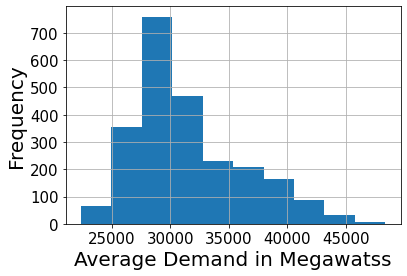

In [11]:
#Histograma
series = df_daily["avg_mgw_demand"]
series.hist()
plt.xlabel("Average Demand in Megawatss", fontsize=20)
plt.ylabel("Frequency", fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
pyplot.show()

There's a concentration of demand from 25k to about 40k megawatts on average per day

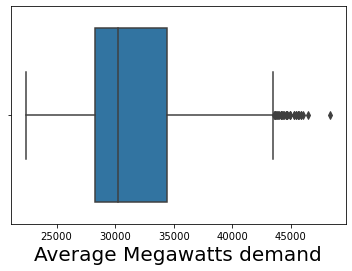

In [12]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_daily['avg_mgw_demand'])
plt.xlabel("Average Megawatts demand", fontsize=20)
plt.show()

The BoxPlot shows that on average the demand are inside that blue box, however there's an Outlier that sums more than 45k

For a better understanding let's check the BoxPlot for each year and each month for the two datasets

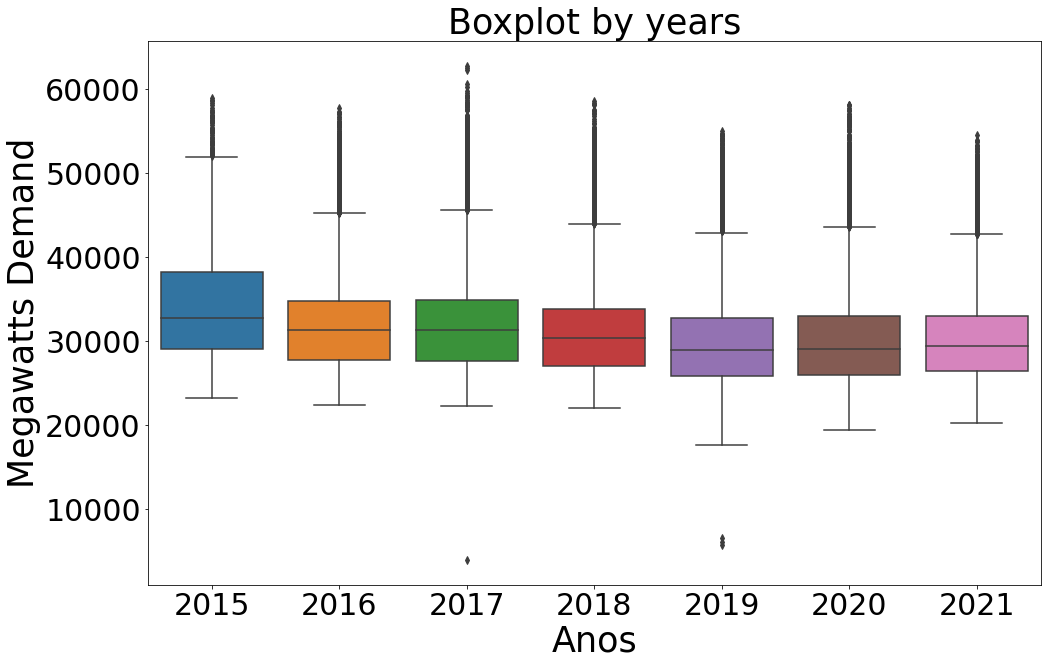

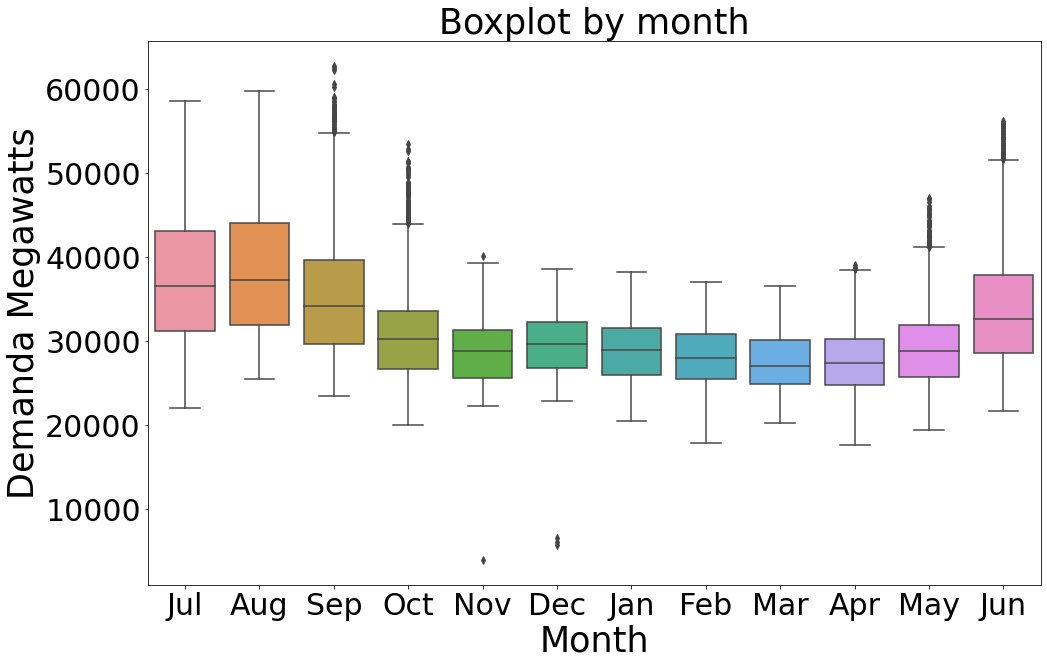

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
#%% Boxplots
"""[2]"""
df_boxplot = df_hourly
time= df_boxplot.set_index('time')
df_boxplot.index = df_boxplot['time']

df_boxplot['year'] = [d.year for d in df_boxplot.index]
df_boxplot['month'] = [d.strftime("%b") for d in df_boxplot.index]

plt.figure(figsize=(16,10))
sns.boxplot(x='year', y='mgw_demand', data=df_boxplot)
plt.ylabel("Megawatts Demand", fontsize=35)
plt.xlabel("Anos", fontsize=35)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.title('Boxplot by years',fontsize=35)
plt.show()

plt.figure(figsize=(16,10))
sns.boxplot(x='month', y='mgw_demand', data=df_boxplot)
plt.ylabel("Demanda Megawatts", fontsize=35)
plt.xlabel("Month", fontsize=35)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.title('Boxplot by month',fontsize=35)
plt.show()

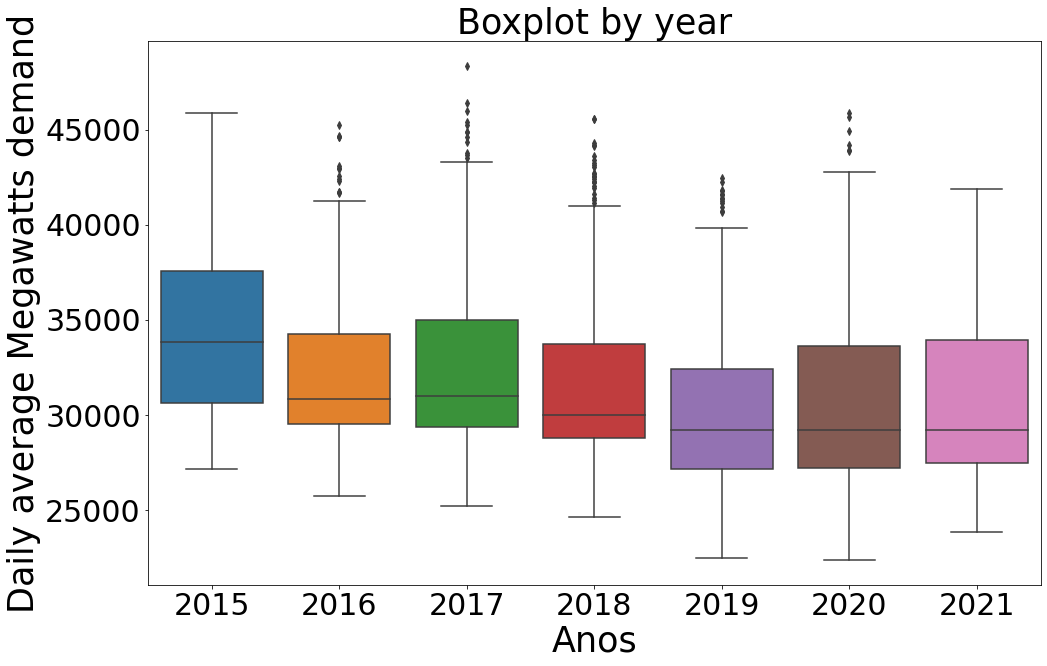

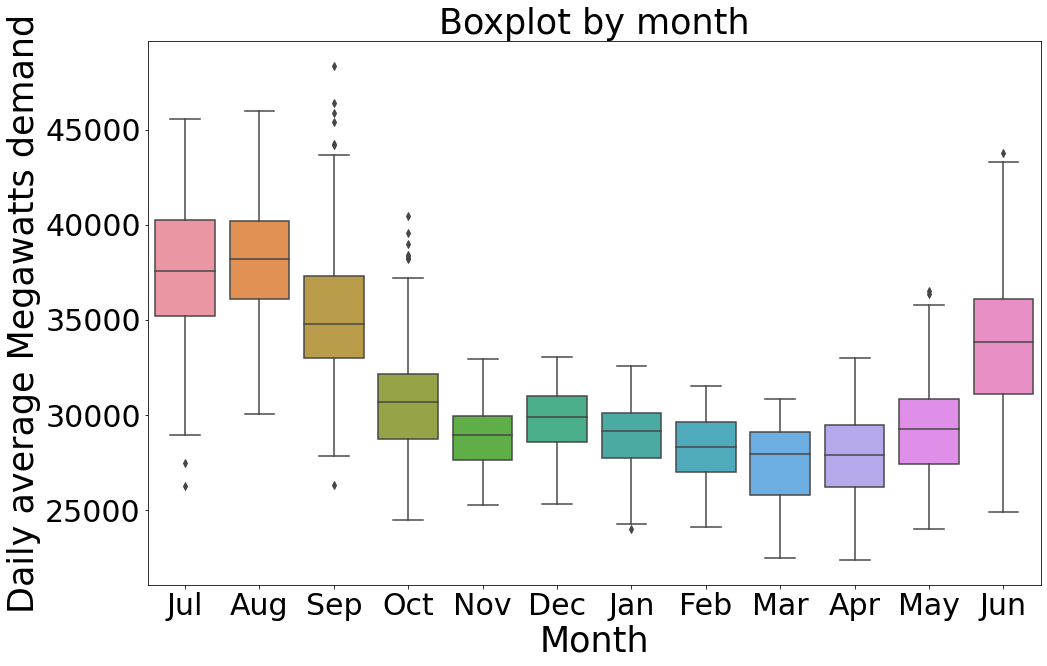

In [14]:
#%% Boxplots
"""[2]"""
df_boxplot = df_daily
time= df_boxplot.set_index('time')
df_boxplot.index = df_boxplot['time']

df_boxplot['year'] = [d.year for d in df_boxplot.index]
df_boxplot['month'] = [d.strftime("%b") for d in df_boxplot.index]

plt.figure(figsize=(16,10))
sns.boxplot(x='year', y='avg_mgw_demand', data=df_boxplot)
plt.ylabel("Daily average Megawatts demand", fontsize=35)
plt.xlabel("Anos", fontsize=35)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.title('Boxplot by year',fontsize=35)
plt.show()

plt.figure(figsize=(16,10))
sns.boxplot(x='month', y='avg_mgw_demand', data=df_boxplot)
plt.ylabel("Daily average Megawatts demand", fontsize=35)
plt.xlabel("Month", fontsize=35)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.title('Boxplot by month',fontsize=35)
plt.show()

The BoxPlot graphs shows us a couple of interesting things:
The average consumption by month and year;
The presence of Outliers;
The sazonality in eletricity consumption (reduction from October to May).

IN order to deal with the Outliers we must clean them.
The method chosed to clear the outliers was to keep only the data inside 3 standard deviations from the normal distribution.

In [15]:
df_daily_outlierclean = df_daily[np.abs(df_daily.avg_mgw_demand-df_daily.avg_mgw_demand.mean()) <= (3*df_daily.avg_mgw_demand.std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'mgw_demand_log'.

In [16]:
df_hourly_outlierclean = df_hourly[np.abs(df_hourly.mgw_demand-df_hourly.mgw_demand.mean()) <= (3*df_hourly.mgw_demand.std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'mgw_demand_log'.

DATA IN GRAPHS

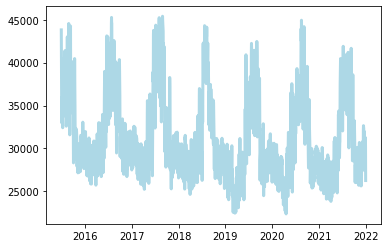

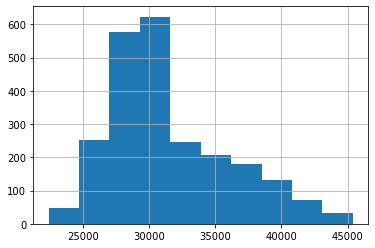

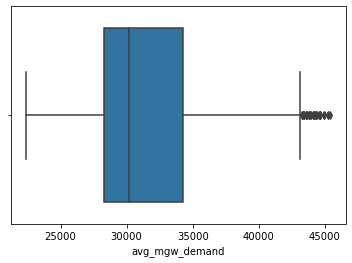

In [17]:
import matplotlib.pyplot as plt
x = df_daily_outlierclean["time"]
y = df_daily_outlierclean["avg_mgw_demand"]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.show()

#Histograma
series = df_daily_outlierclean["avg_mgw_demand"]
series.hist()
pyplot.show()

# Check for outliers in 'pressure' column

sns.boxplot(x=df_daily_outlierclean['avg_mgw_demand'])
plt.show()

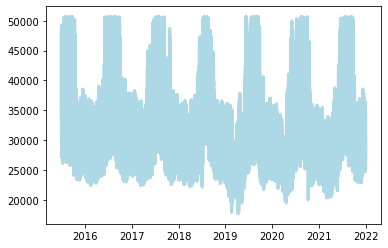

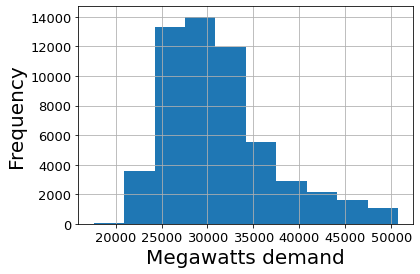

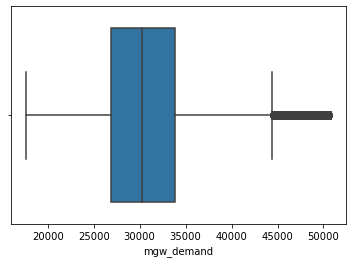

In [18]:
import matplotlib.pyplot as plt
x = df_hourly_outlierclean["time"]
y = df_hourly_outlierclean["mgw_demand"]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.show()

#Histograma
series = df_hourly_outlierclean["mgw_demand"]
series.hist()
plt.xlabel("Megawatts demand", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
pyplot.show()

# Check for outliers in 'pressure' column

sns.boxplot(x=df_hourly_outlierclean['mgw_demand'])
plt.show()

The graphs shows that the data distribution after the Outliers removal.

In [19]:
# identify outliers with interquartile range
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
# generate univariate observations
data = df_daily_outlierclean["avg_mgw_demand"]
# calculate interquartile range
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=28277.710, 75th=34254.900, IQR=5977.190
Identified outliers: 29
Non-outlier observations: 2338


In [20]:
df_daily_outlierclean1 = df_daily_outlierclean[df_daily_outlierclean["avg_mgw_demand"] > 28277.710]

In [21]:
df_daily_outlierclean2 = df_daily_outlierclean[df_daily_outlierclean["avg_mgw_demand"] < 34254.900]

In [22]:
df_daily_outlierclean2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1775 entries, 2015-07-05 00:00:00+00:00 to 2021-12-31 00:00:00+00:00
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   year                    1775 non-null   int64              
 1   day                     1775 non-null   object             
 2   time                    1775 non-null   datetime64[ns, UTC]
 3   avg_mgw_demand          1775 non-null   float64            
 4   avg_temp_cities         1775 non-null   float64            
 5   avg_los_angeles_temp    1775 non-null   float64            
 6   avg_san_diego_temp      1775 non-null   float64            
 7   avg_san_francisco_temp  1775 non-null   float64            
 8   avg_san_jose_temp       1775 non-null   float64            
 9   month                   1775 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(2)
m

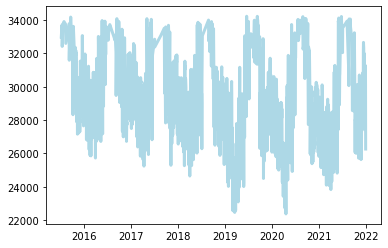

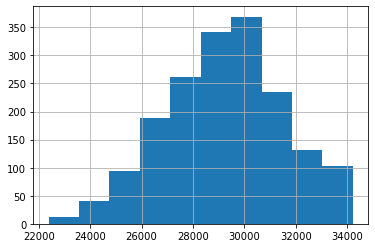

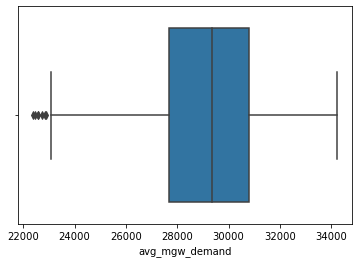

In [23]:
import matplotlib.pyplot as plt
x = df_daily_outlierclean2["time"]
y = df_daily_outlierclean2["avg_mgw_demand"]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.show()

#Histograma
series = df_daily_outlierclean2["avg_mgw_demand"]
series.hist()
pyplot.show()

# Check for outliers in 'pressure' column

sns.boxplot(x=df_daily_outlierclean2["avg_mgw_demand"])
plt.show()

The Outlier removal through the 25th and 75th percentile is still not enough for ARIMA and LSTM forecasting, as the distribution is still not normal.

We will perform a log transformation in order to make the data stationary.

In [24]:
import numpy as np
df_daily_outlierclean['mgw_demand_log'] = np.log(df_daily_outlierclean['avg_mgw_demand'])

C:\Users\Leopardo\AppData\Local\Temp\ipykernel_14736\3499572774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_outlierclean['mgw_demand_log'] = np.log(df_daily_outlierclean['avg_mgw_demand'])


C:\Users\Leopardo\AppData\Local\Temp\ipykernel_14736\1134496550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_outlierclean['mgw_demand_log_diff'] = df_daily_outlierclean['mgw_demand_log'] - df_daily_outlierclean['mgw_demand_log'].shift(1)


<AxesSubplot:xlabel='time'>

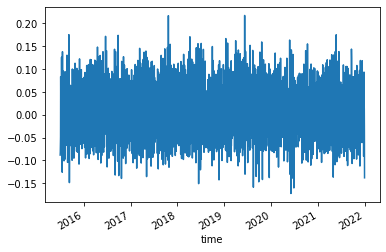

In [25]:
df_daily_outlierclean['mgw_demand_log_diff'] = df_daily_outlierclean['mgw_demand_log'] - df_daily_outlierclean['mgw_demand_log'].shift(1)
df_daily_outlierclean['mgw_demand_log_diff'].dropna().plot()

In [26]:
df_daily_outlierclean['mgw_diff'] = np.log(df_daily_outlierclean['avg_mgw_demand']/df_daily_outlierclean['avg_mgw_demand'].shift(1)).dropna()

C:\Users\Leopardo\AppData\Local\Temp\ipykernel_14736\3796719381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_outlierclean['mgw_diff'] = np.log(df_daily_outlierclean['avg_mgw_demand']/df_daily_outlierclean['avg_mgw_demand'].shift(1)).dropna()


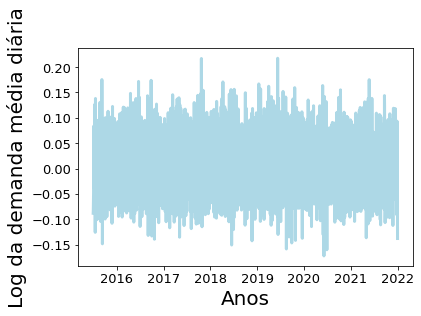

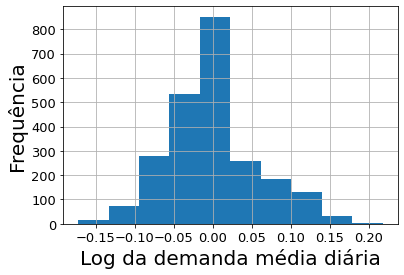

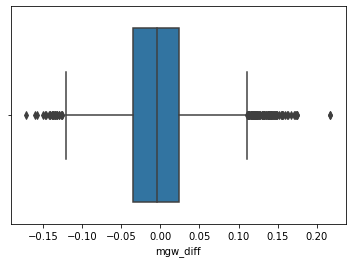

In [28]:
import matplotlib.pyplot as plt
x = df_daily_outlierclean["time"]
y = df_daily_outlierclean["mgw_diff"]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.ylabel("Log da demanda média diária", fontsize=20)
plt.xlabel("Anos", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

#Histograma
series = df_daily_outlierclean["mgw_diff"]
plt.ylabel("Frequência", fontsize=20)
plt.xlabel("Log da demanda média diária", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
series.hist()

pyplot.show()

# Check for outliers in 'pressure' column

sns.boxplot(x=df_daily_outlierclean['mgw_diff'])
plt.show()

The first graph shows that data is stationary, the second shows a normal frequency distribution and the last one the boxplot showing the concentration near the average.

In [29]:
# identify outliers with interquartile range
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
# generate univariate observations
data = df_hourly_outlierclean["mgw_demand"]
# calculate interquartile range
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=26836.000, 75th=33856.000, IQR=7020.000
Identified outliers: 2537
Non-outlier observations: 53678


In [30]:
df_hourly_outlierclean1 = df_hourly_outlierclean[df_hourly_outlierclean["mgw_demand"] >= 26836.000]
df_hourly_outlierclean2 = df_hourly_outlierclean1[df_hourly_outlierclean1["mgw_demand"] <= 33856.000]

<AxesSubplot:xlabel='time'>

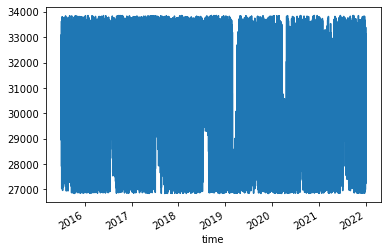

In [31]:
df_hourly_outlierclean2['mgw_demand'].plot()

C:\Users\Leopardo\AppData\Local\Temp\ipykernel_14736\3463946106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hourly_outlierclean['mgw_demand_log_diff'] = df_hourly_outlierclean['mgw_demand'] - df_hourly_outlierclean['mgw_demand'].shift(1)


<AxesSubplot:xlabel='time'>

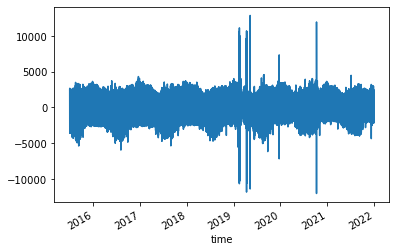

In [34]:
df_hourly_outlierclean['mgw_demand_log_diff'] = df_hourly_outlierclean['mgw_demand'] - df_hourly_outlierclean['mgw_demand'].shift(1)
df_hourly_outlierclean['mgw_demand_log_diff'].dropna().plot()

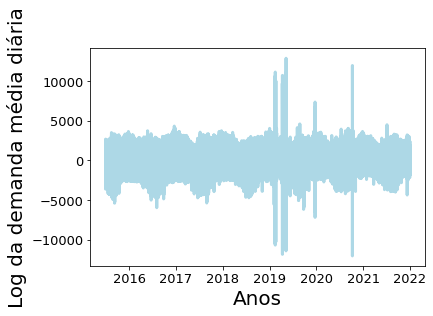

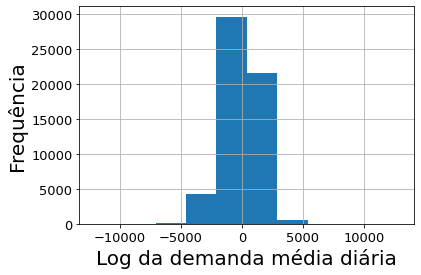

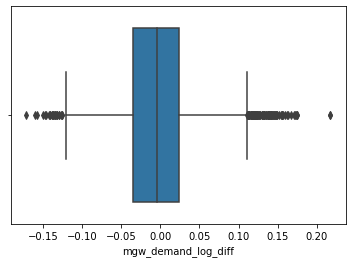

In [36]:
import matplotlib.pyplot as plt
x = df_hourly_outlierclean["time"]
y = df_hourly_outlierclean["mgw_demand_log_diff"]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.ylabel("Log da demanda média diária", fontsize=20)
plt.xlabel("Anos", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

#Histograma
series = df_hourly_outlierclean["mgw_demand_log_diff"]
plt.ylabel("Frequência", fontsize=20)
plt.xlabel("Log da demanda média diária", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
series.hist()

pyplot.show()

# Check for outliers in 'pressure' column

sns.boxplot(x=df_daily_outlierclean['mgw_demand_log_diff'])
plt.show()

ARIMA Model applied to Average Daily Demand

In [37]:
# ARIMA library imports

from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [38]:
df_daily_outlierclean2 = df_daily_outlierclean.dropna()

In order to test stationarity we use the ADF test (Augmented Dicker Fuller) included in the “Statsmodels” library.
The test consists of evaluating two hypothesys:

Null Hypothesis (H0): If not rejected, suggests that the time series has a unit root, which means that it is not stationary. Has any dependent structure of time.

Alternative Hypothesis (H1): The null hypothesis is rejected; suggests that the time series does not have a unit root, which means it is stationary. has no structure time dependent.

This result is interpreted from the p-value of the test. A p value below a stipulated threshold (1%, 5% or 10%) suggests rejecting the null hypothesis (stationary), otherwise, a p value above the threshold suggests not rejection of the null hypothesis (non-stationary). p-value > 0.05: Failed to reject the null hypothesis (H0), the data have a unit root and are not stationary. p-value <= 0.05: The null hypothesis (H0) is rejected, the data have no unit root and are stationary.

In [39]:
# Testar ADF para Stacionarity
series = df_daily_outlierclean2['mgw_diff']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.379390
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We reject the null hypothesis, thus, the Data seems to be stationary.

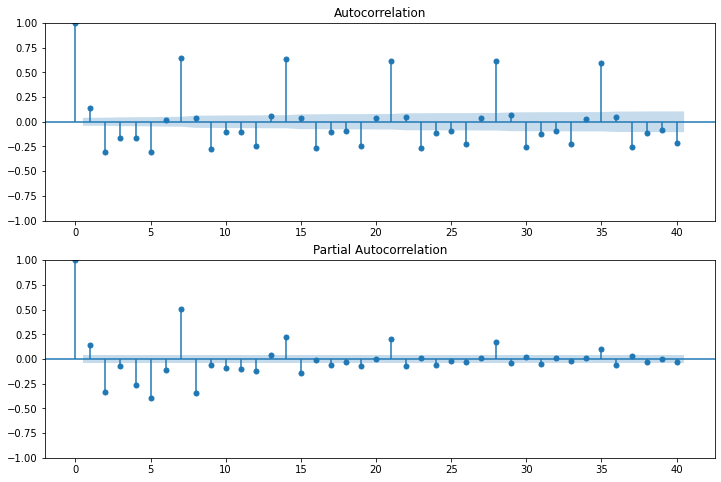

In [40]:
# Printar PACS

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily_outlierclean2["mgw_diff"].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily_outlierclean2["mgw_diff"].dropna(),lags=40,ax=ax2)

To define the parameters of the ARIMA tests there are
the PACS (Partial Autocorrelation statistics) autocorrelation tests. The graph indicates the values outside the range
confidence in light blue the order of the AR model, in
that from the third observation onwards, there is a negative correlation, that is, only two previous hours are
needed to account for demand for the next hour.

In [41]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df_daily_outlierclean2['mgw_diff'], 
                      start_p=2, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)


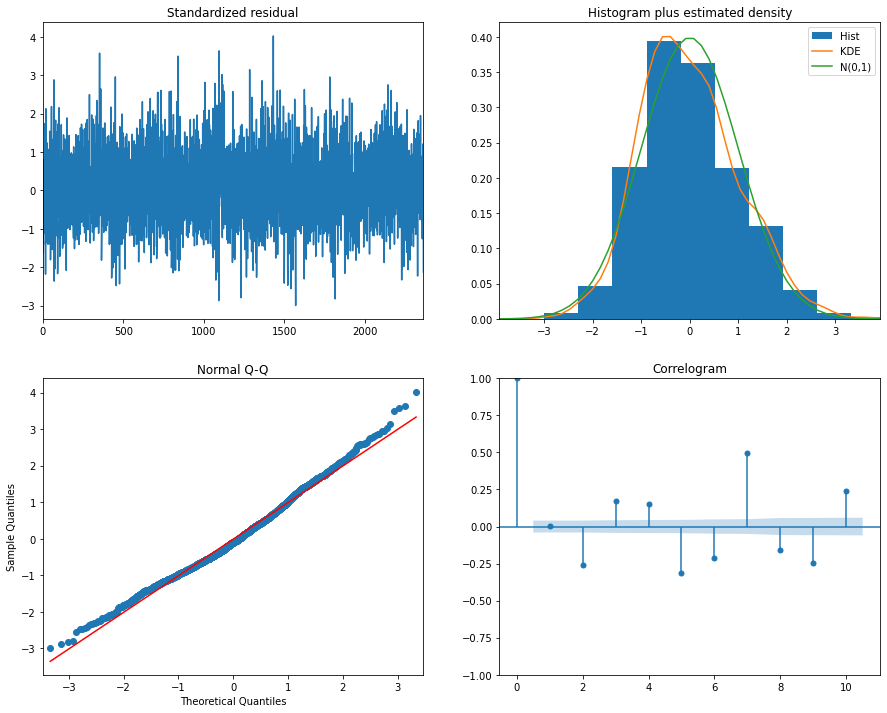

In [42]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Standarized Residual:
The x-axis indicates the t-value and the y-axis the degree
correlation. The graph shows that only the first
hour is enough to explain the next one within the
MA model. With this we determine the parameters (p,d
and q) from the daily and hourly analysis as (2,0,1)

Histogram plus estimated density:
The x axis represents the values in
log and the y-axis the frequency at which they appear. The data
logs with logarithmic transformation got very low errors
and a distribution close to a normal one.
The KDE estimator (Kernel density estimator) that brings the
function of the density distribution of the shape data
smoothed, while the blue bars shows the shape
static. The function N(0,1) shows the normal distribution function.

Normal Q-Q:
The x axis is the theoretical quantiles and the Y axis the sample quantiles. the graph “Normal Q-Q” shows how close the frequency distribution of the data is to a normal distribution.

In [43]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = df_daily_outlierclean2['mgw_diff']
# split into train and test sets
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


predicted=-0.018441, expected=0.090909
predicted=0.026267, expected=0.002263
predicted=-0.012162, expected=-0.023553
predicted=0.023689, expected=0.008226
predicted=0.007876, expected=-0.022613
predicted=-0.025150, expected=-0.082730
predicted=-0.047949, expected=-0.012012
predicted=-0.011646, expected=0.097264
predicted=0.027757, expected=0.011053
predicted=-0.004925, expected=0.005186
predicted=0.044283, expected=-0.001911
predicted=0.003149, expected=-0.014068
predicted=-0.006667, expected=-0.075473
predicted=-0.048251, expected=-0.028767
predicted=-0.019197, expected=0.135193
predicted=0.056423, expected=0.029819
predicted=-0.002848, expected=0.000636
predicted=0.056376, expected=-0.026511
predicted=-0.004280, expected=-0.021055
predicted=-0.011374, expected=-0.077633
predicted=-0.059713, expected=-0.015418
predicted=-0.013471, expected=0.101174
predicted=0.032780, expected=-0.000161
predicted=-0.013913, expected=-0.013271
predicted=0.034923, expected=0.001315
predicted=0.001715, e

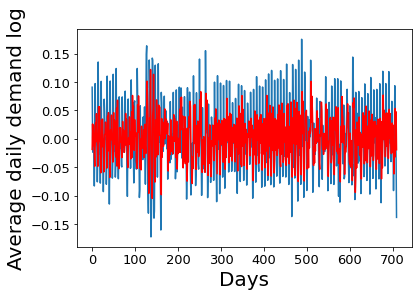

In [44]:
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
plt.xlabel("Days", fontsize=20)
plt.ylabel("Average daily demand log", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
pyplot.show()

TESTE ARIMA PARA DADOS HOURLY


First remove the Outliers like we did with the daily data

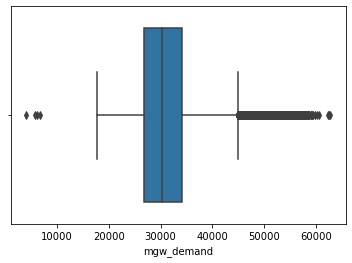

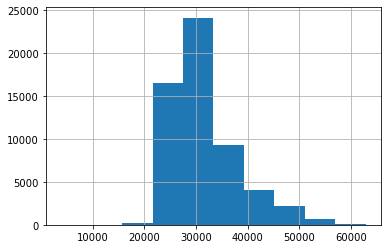

In [45]:
sns.boxplot(x=df_hourly['mgw_demand'])
plt.show()
#Histograma
series = df_hourly["mgw_demand"]
series.hist()
pyplot.show()

Remover os Outliers

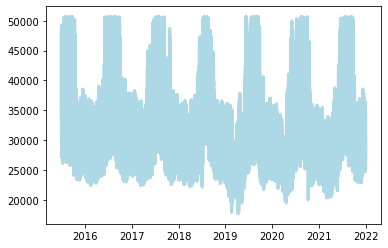

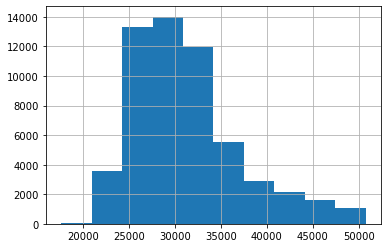

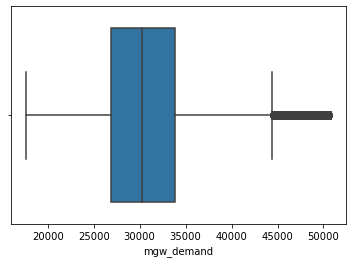

In [46]:
# DISTRIBUICAO DOS DADOS
import matplotlib.pyplot as plt
x = df_hourly_outlierclean["time"]
y = df_hourly_outlierclean["mgw_demand"]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y, color='lightblue', linewidth=3)
plt.savefig('foo.png')
plt.show()

#Histograma
series = df_hourly_outlierclean["mgw_demand"]
series.hist()
pyplot.show()

# Check for outliers in 'pressure' column

sns.boxplot(x=df_hourly_outlierclean['mgw_demand'])
plt.show()

In [47]:
# Testar ADF para Stacionarity
series = df_hourly_outlierclean['mgw_demand']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.820185
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Os resultados não são o suficiente para se crer em stacionariedade. Pois os valores críticos sao maiores que o valor ADF.

In [48]:
#greater than the start date and smaller than the end date
mask = (df_hourly_outlierclean['time'] > '19-Dec-21') & (df_hourly_outlierclean['time'] <= '26-Dec-21')
df_hourly_outlierclean.loc[mask]
df_hourly4 = df_hourly_outlierclean.loc[mask]

In [49]:
# Testar ADF para Stacionarity
series = df_hourly4['mgw_demand']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.357726
p-value: 0.154025
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


Reducing the data to one week shows stationarity

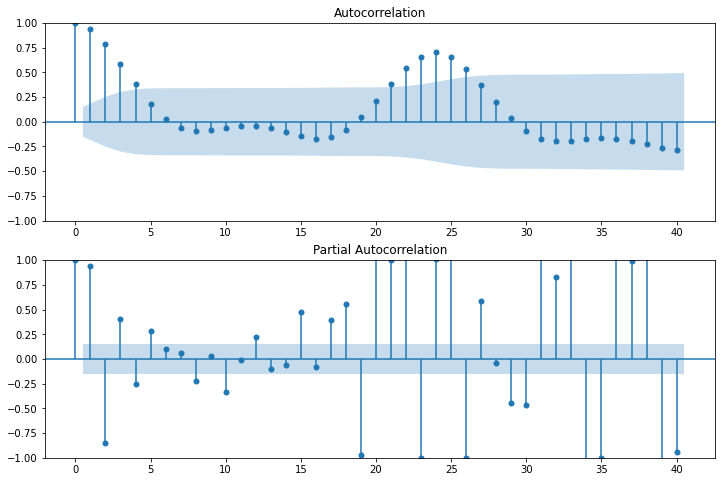

In [50]:
# Printar PACS

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_hourly4["mgw_demand"].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_hourly4["mgw_demand"].dropna(),lags=40,ax=ax2)

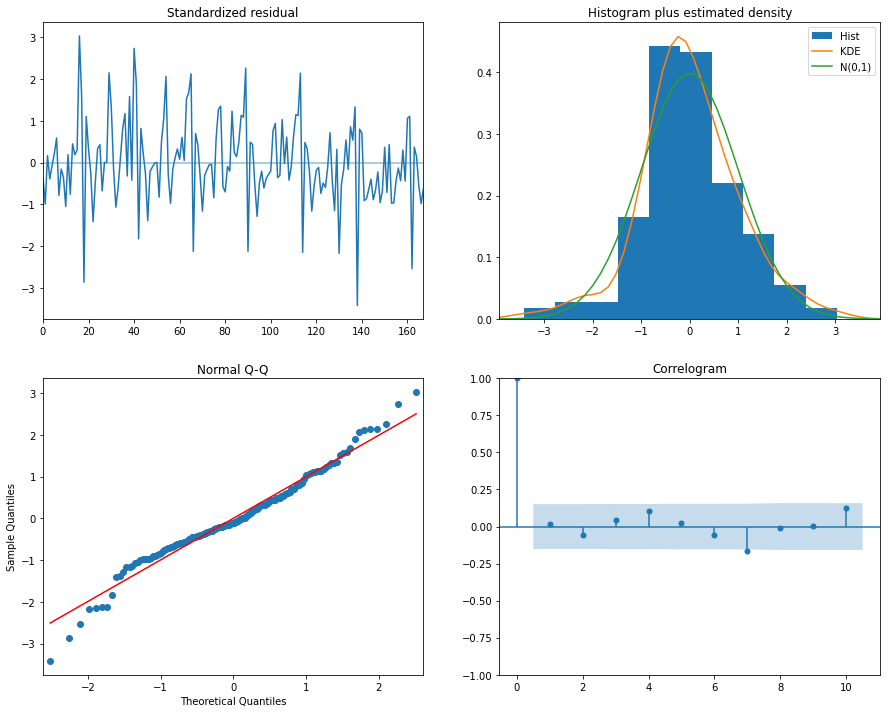

In [51]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df_hourly4['mgw_demand'], 
                      start_p=2, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

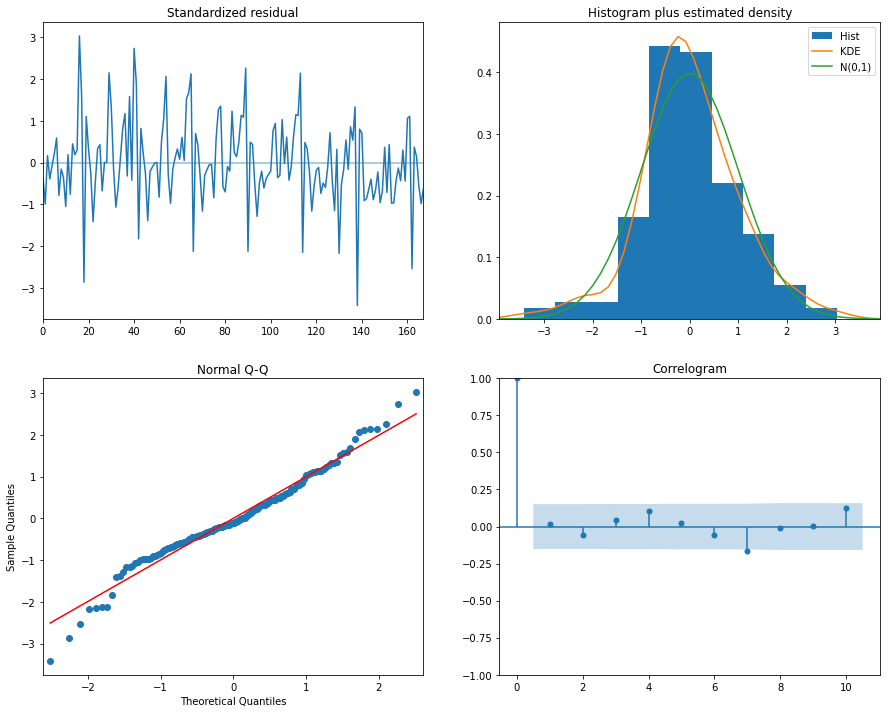

In [52]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [53]:

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = df_hourly4['mgw_demand']
# split into train and test sets
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


predicted=33106.642201, expected=32330.000000
predicted=32028.294654, expected=30641.000000
predicted=30135.833056, expected=28845.000000
predicted=28287.308394, expected=27473.000000
predicted=27029.679174, expected=26685.000000
predicted=26421.050044, expected=26063.000000
predicted=25858.288810, expected=25680.000000
predicted=25550.634675, expected=25461.000000
predicted=25386.237874, expected=25659.000000
predicted=25717.702640, expected=26694.000000
predicted=27023.311263, expected=27662.000000
predicted=27984.814638, expected=27892.000000
predicted=27976.553085, expected=28284.000000
predicted=28414.204133, expected=27468.000000
predicted=27208.184535, expected=26519.000000
predicted=26200.263421, expected=25982.000000
predicted=25797.353648, expected=26334.000000
predicted=26450.344289, expected=27001.000000
predicted=27228.129401, expected=28336.000000
predicted=28792.326596, expected=29939.000000
predicted=30493.247000, expected=31997.000000
predicted=32717.324480, expected=3

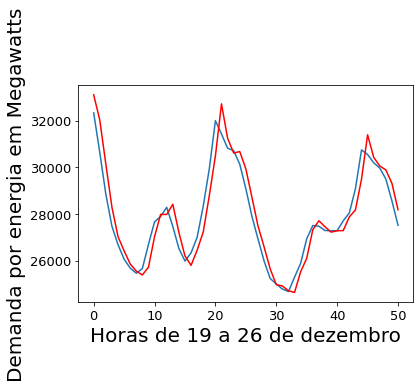

In [54]:
# plot forecasts against actual outcomes
y1= test
y2 = predictions
base_final = df_hourly4["time"]

pyplot.plot(y1)
pyplot.plot(y2, color='red')
plt.xlabel("Horas de 19 a 26 de dezembro", fontsize=20)
plt.ylabel("Demanda por energia em Megawatts", fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
pyplot.show()

DF Hourly transformado em Log

In [95]:
df_hourly_outlierclean.describe()

,Hour,year,mgw_demand,los_angeles_temp,san_diego_temp,san_francisco_temp,san_jose_temp,avg_temp_cities,mgw_demand_log_diff
count,56215.000000,56215.000000,56215.000000,56215.000000,56215.000000,56215.000000,56215.000000,56215.000000,56214.000000
mean,12.427555,2018.237019,31214.534555,18.437447,18.455990,14.736227,15.938031,16.891924,-0.122247
std,6.939200,1.888870,5900.933960,4.828206,4.152544,4.024204,5.739847,4.395611,1418.175120
min,1.000000,2015.000000,17617.000000,3.900000,3.900000,1.700000,-0.600000,2.900000,-12039.000000
25%,6.000000,2017.000000,26836.000000,15.000000,15.600000,12.200000,12.200000,13.775000,-896.000000
50%,12.000000,2018.000000,30229.000000,18.300000,18.300000,14.400000,15.600000,16.800000,69.000000
75%,18.000000,2020.000000,33856.000000,21.700000,21.100000,17.200000,19.400000,19.600000,962.000000
max,24.000000,2021.000000,50741.000000,42.800000,37.200000,36.100000,39.400000,36.100000,12865.000000


In [101]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df_hourly_outlierclean['mgw_demand_log_diff'].values, order=(2,0,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                56215
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -452838.024
Date:                Sun, 14 Aug 2022   AIC                         905686.048
Time:                        01:00:18   BIC                         905730.732
Sample:                             0   HQIC                        905699.969
                              - 56215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2627      0.838     -0.314      0.754      -1.905       1.380
ar.L1          1.7482      0.002    953.833      0.000       1.745       1.752
ar.L2         -0.8418      0.002   -555.555      0.0

In [102]:
train = df_hourly_outlierclean['mgw_demand_log_diff'].values


In [103]:
prediction = model.predict()

<function matplotlib.pyplot.show(close=None, block=None)>

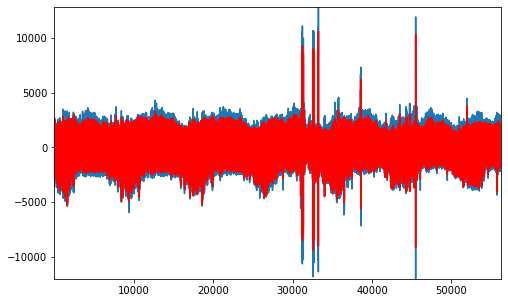

In [104]:
plt.figure(figsize=(8,5))
plt.plot(train, label="Training")
plt.plot(prediction, label="Predicted", color='red')
plt.xlim([1, 56215])
plt.ylim([-12039, 12865])
plt.show

In [86]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(train, prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 800.652


LSTM model: Define the learning and test dfs

FEATURE ENGINEERING

In [105]:
df_daily5 = df_daily_outlierclean[['avg_mgw_demand', 'mgw_demand_log', 'mgw_demand_log_diff', 'mgw_diff', 'avg_temp_cities', 'avg_los_angeles_temp', 'avg_san_diego_temp', 'avg_san_francisco_temp', 'avg_san_jose_temp']].copy()
df_daily5.dropna()
df_daily5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2367 entries, 2015-07-01 00:00:00+00:00 to 2021-12-31 00:00:00+00:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_mgw_demand          2367 non-null   float64
 1   mgw_demand_log          2367 non-null   float64
 2   mgw_demand_log_diff     2366 non-null   float64
 3   mgw_diff                2366 non-null   float64
 4   avg_temp_cities         2367 non-null   float64
 5   avg_los_angeles_temp    2367 non-null   float64
 6   avg_san_diego_temp      2367 non-null   float64
 7   avg_san_francisco_temp  2367 non-null   float64
 8   avg_san_jose_temp       2367 non-null   float64
dtypes: float64(9)
memory usage: 184.9 KB


In [106]:
df_hourly_outlierclean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56215 entries, 2015-07-01 08:00:00+00:00 to 2021-12-31 07:00:00+00:00
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Local date           56215 non-null  object             
 1   Hour                 56215 non-null  int64              
 2   week_day             56215 non-null  object             
 3   month                56215 non-null  object             
 4   year                 56215 non-null  int64              
 5   time                 56215 non-null  datetime64[ns, UTC]
 6   mgw_demand           56215 non-null  int64              
 7   los_angeles_temp     56215 non-null  float64            
 8   san_diego_temp       56215 non-null  float64            
 9   san_francisco_temp   56215 non-null  float64            
 10  san_jose_temp        56215 non-null  float64            
 11  avg_temp_cities      56215 non-nu

In [107]:
df_daily5.drop(['mgw_diff', 'mgw_demand_log_diff', 'avg_mgw_demand', 'avg_temp_cities'], axis=1, inplace=True)

In [108]:
df_daily5.dropna()
df_daily5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2367 entries, 2015-07-01 00:00:00+00:00 to 2021-12-31 00:00:00+00:00
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mgw_demand_log          2367 non-null   float64
 1   avg_los_angeles_temp    2367 non-null   float64
 2   avg_san_diego_temp      2367 non-null   float64
 3   avg_san_francisco_temp  2367 non-null   float64
 4   avg_san_jose_temp       2367 non-null   float64
dtypes: float64(5)
memory usage: 111.0 KB


In [109]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57001 entries, 2015-07-01 08:00:00+00:00 to 2021-12-31 07:00:00+00:00
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Local date          57001 non-null  object             
 1   Hour                57001 non-null  int64              
 2   week_day            57001 non-null  object             
 3   month               57001 non-null  object             
 4   year                57001 non-null  int64              
 5   time                57001 non-null  datetime64[ns, UTC]
 6   mgw_demand          57001 non-null  int64              
 7   los_angeles_temp    57001 non-null  float64            
 8   san_diego_temp      57001 non-null  float64            
 9   san_francisco_temp  57001 non-null  float64            
 10  san_jose_temp       57001 non-null  float64            
 11  avg_temp_cities     57001 non-null  float64   

LSTM FOR HOURLY DATA

In [134]:
lstm_hourly = df_hourly_outlierclean[['mgw_demand', 'mgw_demand_log_diff', 'time', 'avg_temp_cities', 'los_angeles_temp', 'san_diego_temp', 'san_francisco_temp', 'san_jose_temp']].copy()

In [136]:
lstm_hourly.dropna()

,mgw_demand,mgw_demand_log_diff,time,avg_temp_cities,los_angeles_temp,san_diego_temp,san_francisco_temp,san_jose_temp
time,,,,,,,,
2015-07-01 09:00:00+00:00,37003,2520.0,2015-07-01 09:00:00+00:00,20.975,22.2,21.7,18.3,21.7
2015-07-01 10:00:00+00:00,39274,2271.0,2015-07-01 10:00:00+00:00,23.325,23.9,23.3,20.0,26.1
2015-07-01 11:00:00+00:00,41265,1991.0,2015-07-01 11:00:00+00:00,24.425,23.9,23.3,21.1,29.4
2015-07-01 12:00:00+00:00,43042,1777.0,2015-07-01 12:00:00+00:00,25.850,26.1,25.6,22.8,28.9
2015-07-01 13:00:00+00:00,44869,1827.0,2015-07-01 13:00:00+00:00,25.550,25.6,27.2,21.1,28.3
...,...,...,...,...,...,...,...,...
2021-12-31 03:00:00+00:00,25624,-633.0,2021-12-31 03:00:00+00:00,9.425,9.4,13.3,8.3,6.7
2021-12-31 04:00:00+00:00,25258,-366.0,2021-12-31 04:00:00+00:00,8.475,10.0,12.2,5.6,6.1
2021-12-31 05:00:00+00:00,25444,186.0,2021-12-31 05:00:00+00:00,8.600,8.3,12.8,8.3,5.0


LSTM Model

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [239]:
lstm_hourly['mgw_demand_log_diff'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 56215 entries, 2015-07-01 08:00:00+00:00 to 2021-12-31 07:00:00+00:00
Series name: mgw_demand_log_diff
Non-Null Count  Dtype  
--------------  -----  
56214 non-null  float64
dtypes: float64(1)
memory usage: 878.4 KB


In [240]:
df_lstm_hourly2 = df_lstm_hourly = lstm_hourly[['mgw_demand_log_diff']].copy()

In [241]:
df_lstm_hourly2.head()

,mgw_demand_log_diff
time,
2015-07-01 08:00:00+00:00,NaN
2015-07-01 09:00:00+00:00,2520.0
2015-07-01 10:00:00+00:00,2271.0
2015-07-01 11:00:00+00:00,1991.0
2015-07-01 12:00:00+00:00,1777.0


In [242]:
df_lstm_hourly2 = np.nan_to_num(df_lstm_hourly2.astype(np.float32))
print(df_lstm_hourly2)

[[   0.]
 [2520.]
 [2271.]
 ...
 [ 186.]
 [ 987.]
 [1180.]]


In [243]:
array_novo = df_lstm_hourly2#.values
#array_novo.reshape(-1, 1)

In [244]:
array_novo.reshape(-1, 1)

array([[   0.],
       [2520.],
       [2271.],
       ...,
       [ 186.],
       [ 987.],
       [1180.]], dtype=float32)

In [245]:
array_novo.reshape(-1, 1)

array([[   0.],
       [2520.],
       [2271.],
       ...,
       [ 186.],
       [ 987.],
       [1180.]], dtype=float32)

In [246]:
training_set = array_novo

In [247]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [248]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

In [249]:
seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[test_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[test_size:len(y)])))

In [250]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [272]:
num_epochs = 500
learning_rate = 0.01

input_size = 1
hidden_size = 1
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.43539
Epoch: 100, loss: 0.03150
Epoch: 200, loss: 0.02896
Epoch: 300, loss: 0.02480
Epoch: 400, loss: 0.01827


Test prediction

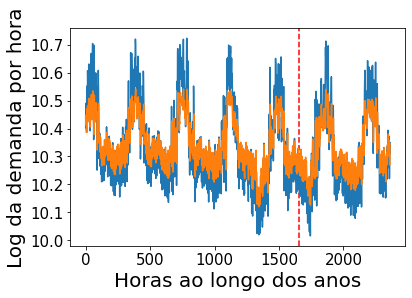

In [273]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.xlabel("Horas ao longo dos anos", fontsize=20)
plt.ylabel("Log da demanda por hora", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

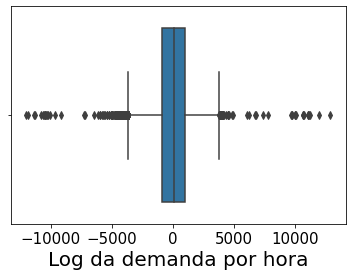

In [274]:
sns.boxplot(x=lstm_hourly['mgw_demand_log_diff'])
plt.xlabel("Log da demanda por hora", fontsize = 20)
plt.xticks(fontsize=15)
plt.show()

In [275]:
mse = sklearn.metrics.mean_squared_error(dataY_plot, data_predict)

rmse = math.sqrt(mse)

print(rmse)

0.07266539111110618


In [276]:
MSE = np.square(np.subtract(dataY_plot,data_predict)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.07266539111110618


BASE DE DADOS DAILY

<AxesSubplot:>

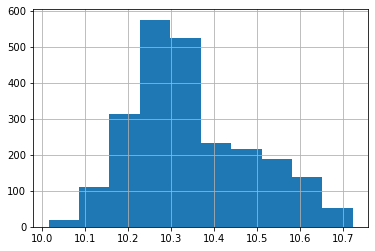

In [265]:
df_daily_outlierclean['mgw_demand_log'].hist()

In [266]:
df_daily_outlierclean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2367 entries, 2015-07-01 00:00:00+00:00 to 2021-12-31 00:00:00+00:00
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   year                    2367 non-null   int64              
 1   day                     2367 non-null   object             
 2   time                    2367 non-null   datetime64[ns, UTC]
 3   avg_mgw_demand          2367 non-null   float64            
 4   avg_temp_cities         2367 non-null   float64            
 5   avg_los_angeles_temp    2367 non-null   float64            
 6   avg_san_diego_temp      2367 non-null   float64            
 7   avg_san_francisco_temp  2367 non-null   float64            
 8   avg_san_jose_temp       2367 non-null   float64            
 9   month                   2367 non-null   object             
 10  mgw_demand_log          2367 non-null   float64            


In [267]:
array_novo = df_daily_outlierclean['mgw_demand_log'].values
array_novo.reshape(-1, 1)

array([[10.68769795],
       [10.59949638],
       [10.51763563],
       ...,
       [10.35025454],
       [10.31390571],
       [10.17593809]])

In [268]:
training_set_daily = array_novo.reshape(-1, 1)

In [269]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set_daily)
seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[test_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[test_size:len(y)])))
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [270]:
num_epochs = 450
learning_rate = 0.01

input_size = 1
hidden_size = 1
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14016
Epoch: 100, loss: 0.00772
Epoch: 200, loss: 0.00670
Epoch: 300, loss: 0.00614
Epoch: 400, loss: 0.00592


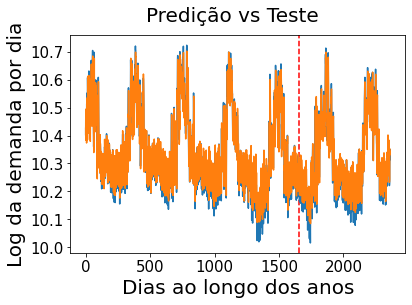

Root Mean Square Error:

0.05366582710085004


In [271]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Predição vs Teste', fontsize=20)
plt.xlabel("Dias ao longo dos anos", fontsize=20)
plt.ylabel("Log da demanda por dia", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()
MSE = np.square(np.subtract(dataY_plot,data_predict)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

FIM